In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from scipy.interpolate import griddata
import numpy as np
import os
import glob
import rioxarray as rio
import rasterio as rio
from pyproj import Transformer
from esda.moran import Moran
from libpysal.weights import lat2W
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from skimage import filters

In [66]:
sheet_names = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
dfs = pd.read_excel('/Users/Azadeh/CRREL.xlsx', sheet_name=sheet_names)
dfs

{'Creamers':      CF_Point       Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
 0         1.0  Creamers-0001    7193915.511    465013.469    134.482   
 1         2.0  Creamers-0002    7193918.897    465011.682    134.302   
 2         3.0  Creamers-0003    7193923.281    465011.427    134.370   
 3         4.0  Creamers-0004    7193927.196    465011.460    134.202   
 4         5.0  Creamers-0005    7193930.739    465010.849    134.077   
 ..        ...            ...            ...           ...        ...   
 124     125.0  CREAMERS-0125    7194401.601    464927.795    137.210   
 125     126.0  CREAMERS-0126    7194405.851    464926.465    137.405   
 126       NaN            NaN            NaN           NaN        NaN   
 127       NaN            NaN            NaN           NaN        NaN   
 128       NaN            NaN            NaN           NaN        NaN   
 
      CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
 0              0.000000            0

In [47]:
df_Creamers = pd.read_excel('/Users/Azadeh/CRREL.xlsx', sheet_name='Creamers')

df_Creamers_selected = df_Creamers.iloc[:, 7:16]

]df_Creamers_selected_transposed = df_Creamers_selected.transpose()

description_selected = df_Creamers_selected_transposed.describe()

df_Creamers_selected_transposed.to_csv('/Users/Azadeh/df_Creamers_selected_transposed.csv')
description_selected.to_csv('/Users/Azadeh/description_selected.csv')
description_selected


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.0,7.000000,7.000000
mean,86.111111,67.666667,68.111111,70.111111,88.000000,82.111111,68.000000,63.000000,74.666667,67.555556,...,91.222222,88.111111,85.444444,60.555556,68.777778,58.444444,84.666667,NaN,71.852599,13.720168
std,20.787282,6.800735,5.441609,3.887301,11.368817,8.237786,5.830952,4.031129,10.920165,3.609401,...,7.395569,4.400126,4.977728,9.408920,8.257993,5.456902,6.103278,NaN,4.501367,2.002072
min,59.000000,57.000000,62.000000,64.000000,75.000000,66.000000,57.000000,58.000000,56.000000,63.000000,...,76.000000,83.000000,76.000000,48.000000,49.000000,52.000000,75.000000,NaN,64.656000,11.398571
25%,73.000000,64.000000,64.000000,67.000000,76.000000,79.000000,65.000000,60.000000,65.000000,65.000000,...,88.000000,84.000000,83.000000,54.000000,68.000000,54.000000,82.000000,NaN,69.400095,11.925167
50%,78.000000,69.000000,67.000000,70.000000,89.000000,82.000000,68.000000,62.000000,79.000000,68.000000,...,93.000000,88.000000,86.000000,65.000000,69.000000,59.000000,86.000000,NaN,72.384000,13.625796
75%,105.000000,70.000000,73.000000,72.000000,95.000000,89.000000,72.000000,66.000000,83.000000,69.000000,...,96.000000,92.000000,87.000000,66.000000,74.000000,61.000000,89.000000,NaN,75.284000,15.618495
max,121.000000,79.000000,78.000000,77.000000,107.000000,93.000000,77.000000,70.000000,87.000000,74.000000,...,99.000000,94.000000,94.000000,75.000000,76.000000,69.000000,91.000000,NaN,76.560000,15.929482


In [33]:
df_Creamers_selected_transposed

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
CF_10_8_14,67.0,70.0,67.0,72.0,76.0,89.0,77.0,70.0,80.0,74.0,...,84.0,87.0,83.0,48.0,66.0,60.0,76.0,NaN,66.97619,11.398571
CF_09_29_15,59.0,57.0,62.0,72.0,89.0,85.0,72.0,66.0,83.0,68.0,...,76.0,83.0,76.0,66.0,49.0,52.0,75.0,NaN,64.65600,12.154320
CF_10_10_16,73.0,64.0,64.0,69.0,75.0,81.0,70.0,67.0,74.0,68.0,...,88.0,94.0,94.0,66.0,68.0,62.0,89.0,NaN,75.36000,11.696015
CF 10_2017,78.0,59.0,63.0,67.0,75.0,75.0,63.0,61.0,56.0,63.0,...,96.0,94.0,87.0,56.0,68.0,59.0,86.0,NaN,71.82400,13.625796
CF 10_5_2018,78.0,69.0,65.0,67.0,84.0,79.0,65.0,58.0,65.0,63.0,...,93.0,92.0,87.0,54.0,69.0,52.0,82.0,NaN,72.38400,15.536006
CF 10_15_19,86.0,69.0,68.0,73.0,93.0,89.0,68.0,62.0,79.0,67.0,...,99.0,88.0,86.0,75.0,74.0,57.0,89.0,NaN,75.20800,15.700984
CF 10_6_20,105.0,79.0,78.0,77.0,107.0,93.0,72.0,64.0,85.0,71.0,...,98.0,88.0,89.0,65.0,75.0,69.0,91.0,NaN,76.56000,15.929482
CF 10_2_21,121.0,69.0,73.0,64.0,95.0,66.0,57.0,60.0,63.0,65.0,...,94.0,84.0,85.0,67.0,74.0,61.0,91.0,NaN,NaN,NaN
CF_9_28_22,108.0,73.0,73.0,70.0,98.0,82.0,68.0,59.0,87.0,69.0,...,93.0,83.0,82.0,48.0,76.0,54.0,83.0,NaN,NaN,NaN


In [54]:
def check_missing_values(dfs):
    missing_values_summary = {}
    for sheet_name, dfs in dfs.items():
        missing_values = dfs.isnull().sum()
        missing_values_summary[sheet_name] = missing_values
    return missing_values_summary

missing_values_summary = check_missing_values(dfs)

for sheet_name, missing_values in missing_values_summary.items():
    print(f"Missing values in sheet '{sheet_name}':")
    print(missing_values)
    print("\n")

Missing values in sheet 'Creamers':
CF_Point              3
Point_ID              3
CF_Northing_m         3
CF_Easting_m          3
CF_Elev_m             3
CF_Dist_previous_m    3
CF_Dist_transect_m    3
CF_10_8_14            1
CF_09_29_15           1
CF_10_10_16           1
CF 10_2017            1
CF 10_5_2018          1
CF 10_15_19           1
CF 10_6_20            1
CF 10_2_21            3
CF_9_28_22            3
CF_Notes_22           3
dtype: int64


Missing values in sheet 'Farmers 1':
FL1_Point              28
Point_ID               28
FL1_Northing_m         28
FL1_Easting_m          28
FL1_Elev_m             28
FL1_Dist_previous_m    28
FL1_Dist_transect_m    28
F1_10_7_14             24
F1_09_29_15            24
F1_10_10_16            24
F1 10_3_2017           26
F1 10_10_18            26
FL1_10_14_19           26
FL1_10_5_20            26
9_30_21                26
FL1_9_27_22            28
Type                   28
dtype: int64


Missing values in sheet 'Farmers 2':
FL2_Point 

In [55]:
def display_nan_rows(dfs):
    for sheet_name, df in dfs.items():
        nan_rows = df[df.isnull().any(axis=1)]
        
        if not nan_rows.empty:
            print(f"Rows with NaN values in sheet '{sheet_name}':")
            print(nan_rows)
            print("\n")
        else:
            print(f"No NaN values in sheet '{sheet_name}'\n")

display_nan_rows(dfs)


Rows with NaN values in sheet 'Creamers':
     CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  
126         NaN         NaN         NaN  
127         NaN         NaN        

In [56]:
def store_nan_rows(dfs):
    nan_rows_dict = {}
    for sheet_name, df in dfs.items():
        nan_rows = df[df.isnull().any(axis=1)]
        nan_rows_dict[sheet_name] = nan_rows
    return nan_rows_dict

nan_rows_dict = store_nan_rows(dfs)

for sheet_name, nan_rows in nan_rows_dict.items():
    if not nan_rows.empty:
        print(f"Rows with NaN values in sheet '{sheet_name}':")
        print(nan_rows)
        print("\n")
    else:
        print(f"No NaN values in sheet '{sheet_name}'\n")


Rows with NaN values in sheet 'Creamers':
     CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  
126         NaN         NaN         NaN  
127         NaN         NaN        

In [57]:
def drop_nan_values(dfs):
    cleaned_dfs = {}
    for sheet_name, df in dfs.items():
        cleaned_df = df.dropna()
        cleaned_dfs[sheet_name] = cleaned_df
    return cleaned_dfs

cleaned_dfs = drop_nan_values(dfs)


In [58]:
new_file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

with pd.ExcelWriter(new_file_path) as writer:
    for sheet_name, cleaned_df in cleaned_dfs.items():
        cleaned_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    nan_combined_df = pd.concat(nan_rows_dict, axis=0)
    nan_combined_df.to_excel(writer, sheet_name='NaN_Values', index=True)


In [61]:
for sheet_name, df in dfs.items():
    print(f"Info for sheet '{sheet_name}':")
    print(df.info())
    print("\n")

Info for sheet 'Creamers':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CF_Point            126 non-null    float64
 1   Point_ID            126 non-null    object 
 2   CF_Northing_m       126 non-null    float64
 3   CF_Easting_m        126 non-null    float64
 4   CF_Elev_m           126 non-null    float64
 5   CF_Dist_previous_m  126 non-null    float64
 6   CF_Dist_transect_m  126 non-null    float64
 7   CF_10_8_14          128 non-null    float64
 8   CF_09_29_15         128 non-null    float64
 9   CF_10_10_16         128 non-null    float64
 10  CF 10_2017          128 non-null    float64
 11  CF 10_5_2018        128 non-null    float64
 12  CF 10_15_19         128 non-null    float64
 13  CF 10_6_20          128 non-null    float64
 14  CF 10_2_21          126 non-null    float64
 15  CF_9_28_22          126 non-nu

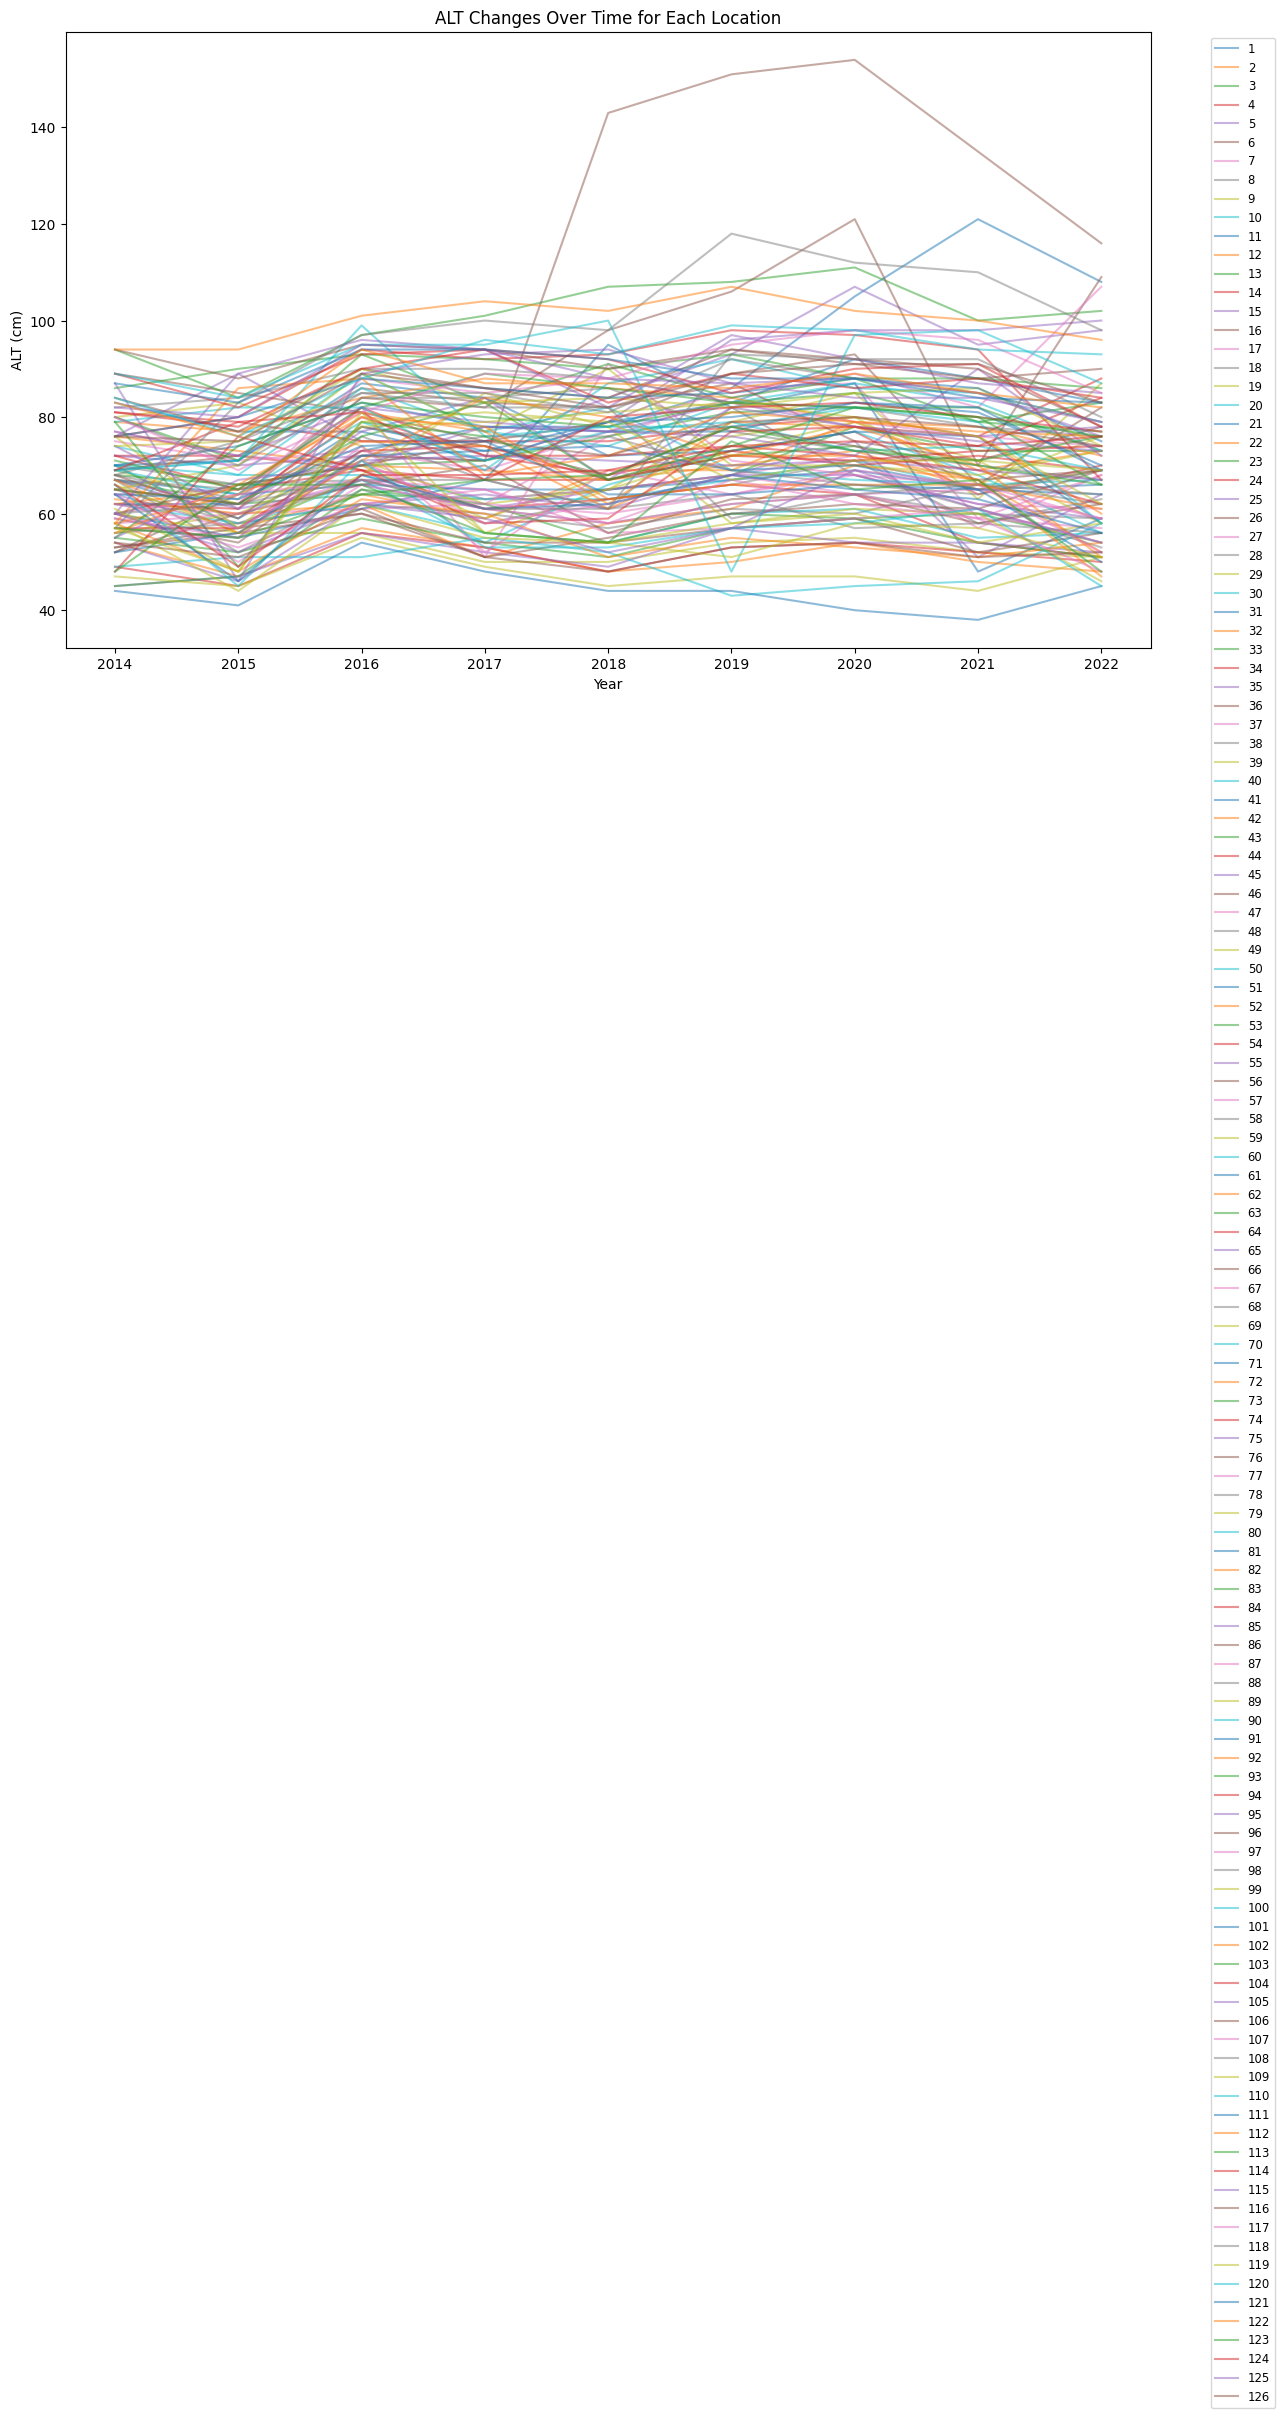

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
df = pd.read_excel(file_path, sheet_name='Creamers')

# Rename columns for easier plotting
df.rename(columns={
    'CF_10_8_14': '2014',
    'CF_09_29_15': '2015',
    'CF_10_10_16': '2016',
    'CF 10_2017': '2017',
    'CF 10_5_2018': '2018',
    'CF 10_15_19': '2019',
    'CF 10_6_20': '2020',
    'CF 10_2_21': '2021',
    'CF_9_28_22': '2022'
}, inplace=True)

# Select only the relevant columns for melting
columns_to_melt = ['CF_Point', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

# Melt the dataframe for easier plotting
df_melted = df[columns_to_melt].melt(id_vars=['CF_Point'], var_name='Year', value_name='ALT')

# Ensure the 'Year' column is of type string
df_melted['Year'] = df_melted['Year'].astype(str)

# Convert non-numeric ALT values to NaN
df_melted['ALT'] = pd.to_numeric(df_melted['ALT'], errors='coerce')

# Plotting individual line plots for each location
plt.figure(figsize=(14, 8))
for location in df_melted['CF_Point'].unique():
    location_data = df_melted[df_melted['CF_Point'] == location]
    plt.plot(location_data['Year'], location_data['ALT'], label=location, alpha=0.5)

plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.title('ALT Changes Over Time for Each Location')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()


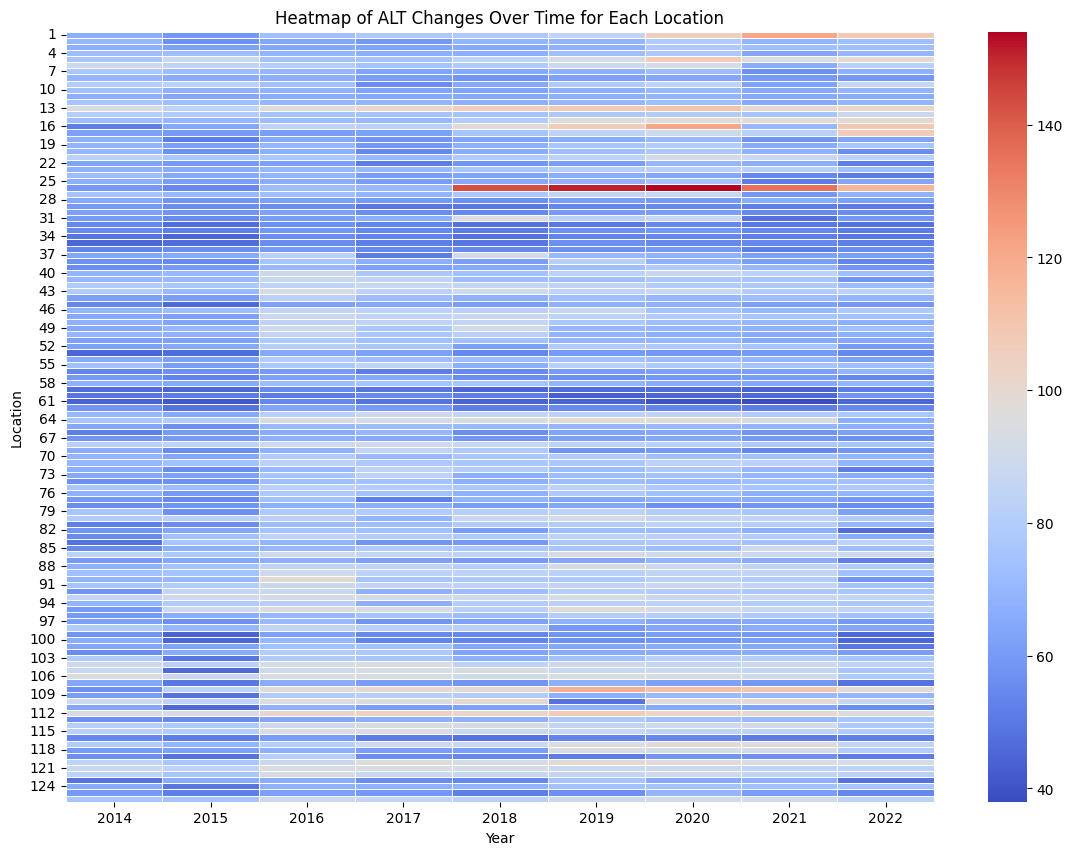

In [46]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
df = pd.read_excel(file_path, sheet_name='Creamers')

# Rename columns for easier plotting
df.rename(columns={
    'CF_10_8_14': '2014',
    'CF_09_29_15': '2015',
    'CF_10_10_16': '2016',
    'CF 10_2017': '2017',
    'CF 10_5_2018': '2018',
    'CF 10_15_19': '2019',
    'CF 10_6_20': '2020',
    'CF 10_2_21': '2021',
    'CF_9_28_22': '2022'
}, inplace=True)

# Select only the relevant columns for melting
columns_to_melt = ['CF_Point', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

# Melt the dataframe for easier plotting
df_melted = df[columns_to_melt].melt(id_vars=['CF_Point'], var_name='Year', value_name='ALT')

# Ensure the 'Year' column is of type string
df_melted['Year'] = df_melted['Year'].astype(str)

# Convert non-numeric ALT values to NaN
df_melted['ALT'] = pd.to_numeric(df_melted['ALT'], errors='coerce')

# Pivot data for heatmap
pivot_table = df_melted.pivot(index='CF_Point', columns='Year', values='ALT')

# Adjust color range for better contrast
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False, linewidths=.5, vmin=df_melted['ALT'].min(), vmax=df_melted['ALT'].max())
plt.title('Heatmap of ALT Changes Over Time for Each Location')
plt.xlabel('Year')
plt.ylabel('Location')
plt.show()


In [63]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

sheet_names = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
excel_file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

gdfs = []

latitude_columns = ['CF_Northing_m', 'FL1_Northing_m', 'FL2_Northing_m', 'PT_Northing_m']
longitude_columns = ['CF_Easting_m', 'FL1_Easting_m', 'FL2_Easting_m', 'PT_Easting_m']

for sheet_name in sheet_names:
    df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    
    lat_col = next((col for col in latitude_columns if col in df.columns), None)
    lon_col = next((col for col in longitude_columns if col in df.columns), None)
    
    if lat_col and lon_col:
        geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry)
        
        gdf.crs = 'EPSG:32606'
        
        gdf = gdf.to_crs(epsg=4326)
        
        gdf['latitude'] = gdf.geometry.y
        gdf['longitude'] = gdf.geometry.x
        
        gdf['Sheet'] = sheet_name
        
        gdfs.append(gdf)
        print(f"Processed sheet '{sheet_name}' with columns '{lat_col}' and '{lon_col}'.")
    else:
        print(f"Missing required columns in sheet '{sheet_name}'.")

if gdfs:
    all_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    
    if not all_gdf.empty:
        map_center = [all_gdf['latitude'].mean(), all_gdf['longitude'].mean()]
        m = folium.Map(location=map_center, zoom_start=10)

        marker_cluster = MarkerCluster().add_to(m)

        for idx, row in all_gdf.iterrows():
            folium.Marker(
                location=[row['latitude'], row['longitude']], 
                popup=f"Point ID: {row.get('CF_Point', 'N/A')}, Sheet: {row['Sheet']}"
            ).add_to(marker_cluster)

        m.save('frost_probing_locations7.html')
        m
        print("Map created and saved successfully.")
    else:
        print("No valid data to plot.")
else:
    print("No GeoDataFrames created from the sheets.")


Processed sheet 'Creamers' with columns 'CF_Northing_m' and 'CF_Easting_m'.
Processed sheet 'Farmers 1' with columns 'FL1_Northing_m' and 'FL1_Easting_m'.
Processed sheet 'Farmers 2' with columns 'FL2_Northing_m' and 'FL2_Easting_m'.
Processed sheet 'Tunnel' with columns 'PT_Northing_m' and 'PT_Easting_m'.
Map created and saved successfully.


In [176]:
import pandas as pd

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
excel_data = pd.ExcelFile(file_path)

average_distances = {}

for sheet in excel_data.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    distance_columns = [col for col in df.columns if col.endswith('_Dist_previous_m')]
    
    for col in distance_columns:
        average_distance = df[col].mean()
        average_distances[f"{sheet}_{col}"] = average_distance

for key, value in average_distances.items():
    print(f"Average distance in {key}: {value:.2f} meters")

average_distances_df = pd.DataFrame(list(average_distances.items()), columns=['Sheet_Column', 'Average_Distance'])
average_distances_df.to_csv('average_distances.csv', index=False)


Average distance in Creamers_CF_Dist_previous_m: 4.00 meters
Average distance in Farmers 1_FL1_Dist_previous_m: 4.02 meters
Average distance in Tunnel_PT_Dist_previous_m: 4.02 meters
Average distance in NaN_Values_CF_Dist_previous_m: nan meters
Average distance in NaN_Values_FL1_Dist_previous_m: nan meters
Average distance in NaN_Values_PT_Dist_previous_m: 3.55 meters


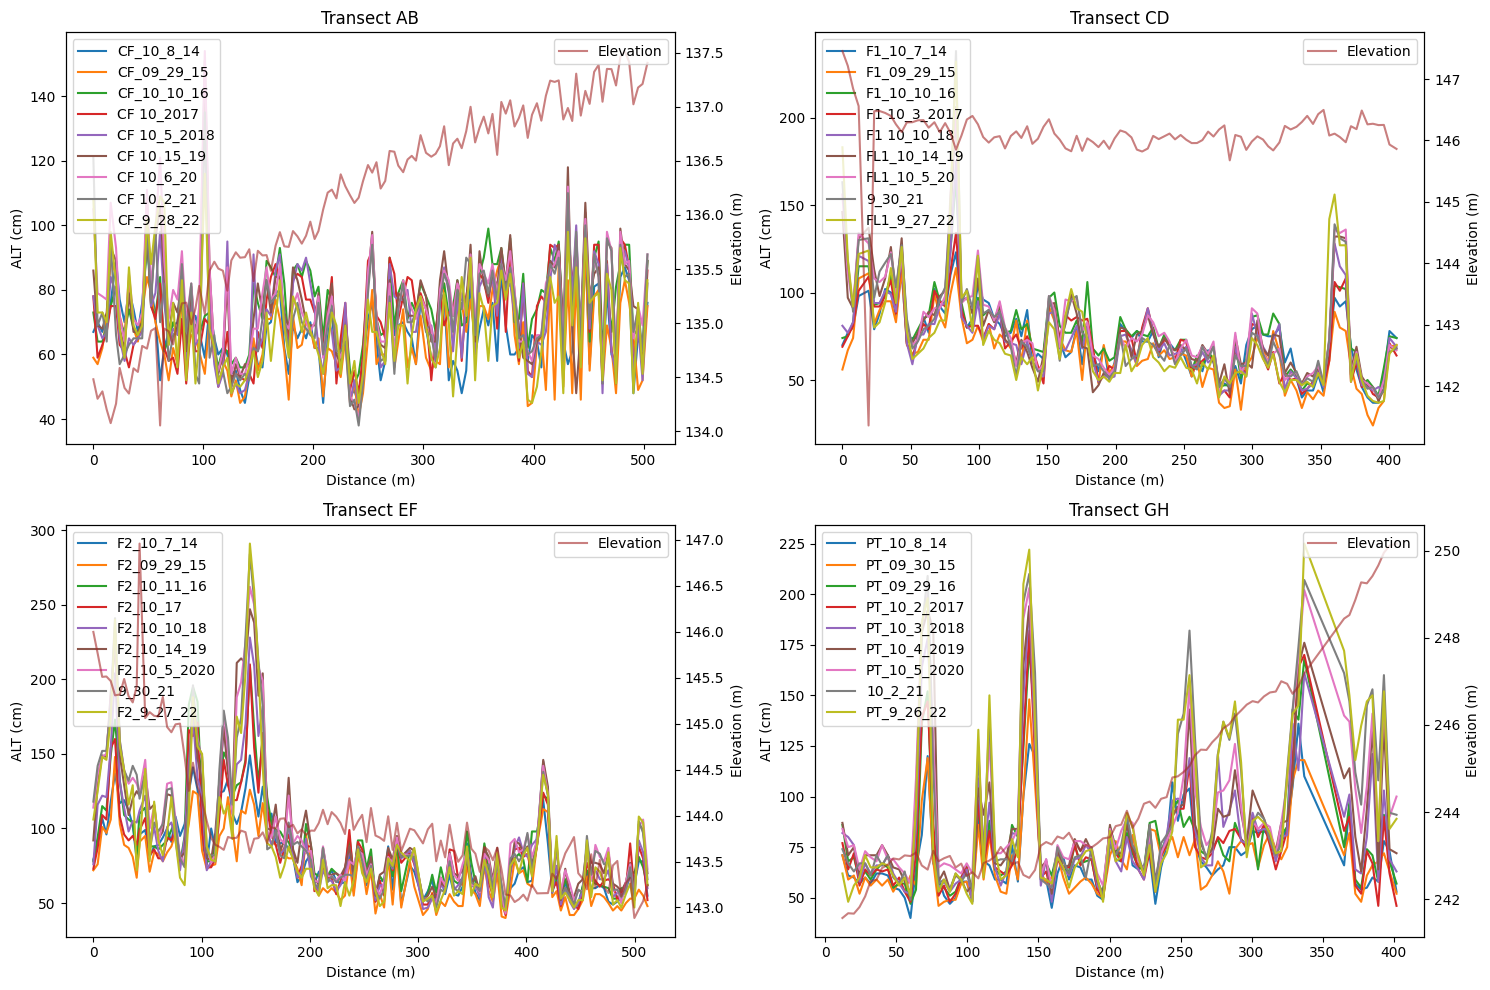

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
titles = ['Transect AB', 'Transect CD', 'Transect EF', 'Transect GH']
distance_cols = ['CF_Dist_transect_m', 'FL1_Dist_transect_m', 'FL2_Dist_transect_m', 'PT_Dist_transect_m']
alt_cols = [
    ['CF_10_8_14', 'CF_09_29_15', 'CF_10_10_16', 'CF 10_2017', 'CF 10_5_2018', 'CF 10_15_19', 'CF 10_6_20', 'CF 10_2_21', 'CF_9_28_22'],
    ['F1_10_7_14', 'F1_09_29_15', 'F1_10_10_16', 'F1 10_3_2017', 'F1 10_10_18', 'FL1_10_14_19', 'FL1_10_5_20', '9_30_21', 'FL1_9_27_22'],
    ['F2_10_7_14', 'F2_09_29_15', 'F2_10_11_16', 'F2_10_17', 'F2_10_10_18', 'F2_10_14_19', 'F2_10_5_2020', '9_30_21', 'F2_9_27_22'],
    ['PT_10_8_14', 'PT_09_30_15', 'PT_09_29_16', 'PT_10_2_2017', 'PT_10_3_2018', 'PT_10_4_2019', 'PT_10_5_2020', '10_2_21', 'PT_9_26_22']
]
elevation_cols = ['CF_Elev_m', 'FL1_Elev_m', 'FL2_Elev_m', 'PT_Elev_m']

def create_subplot(ax, data, distance_col, alt_cols, elevation_col, title):
    data[distance_col] = pd.to_numeric(data[distance_col], errors='coerce')
    
    for col in alt_cols:
        if col in data.columns:
            # Ensure ALT columns are numeric
            data[col] = pd.to_numeric(data[col], errors='coerce')
            ax.plot(data[distance_col], data[col], label=col)
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('ALT (cm)')
    ax.set_title(title)

    ax2 = ax.twinx()
    if elevation_col in data.columns:
        data[elevation_col] = pd.to_numeric(data[elevation_col], errors='coerce')
        ax2.plot(data[distance_col], data[elevation_col], color='brown', alpha=0.6, label='Elevation')
    ax2.set_ylabel('Elevation (m)')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, sheet in enumerate(sheets):
    data = pd.read_excel(file_path, sheet_name=sheet)
    distance_col = distance_cols[i]
    elevation_col = elevation_cols[i]
    ax = axs[i // 2, i % 2]
    create_subplot(ax, data, distance_col, alt_cols[i], elevation_col, titles[i])

plt.tight_layout()
plt.show()

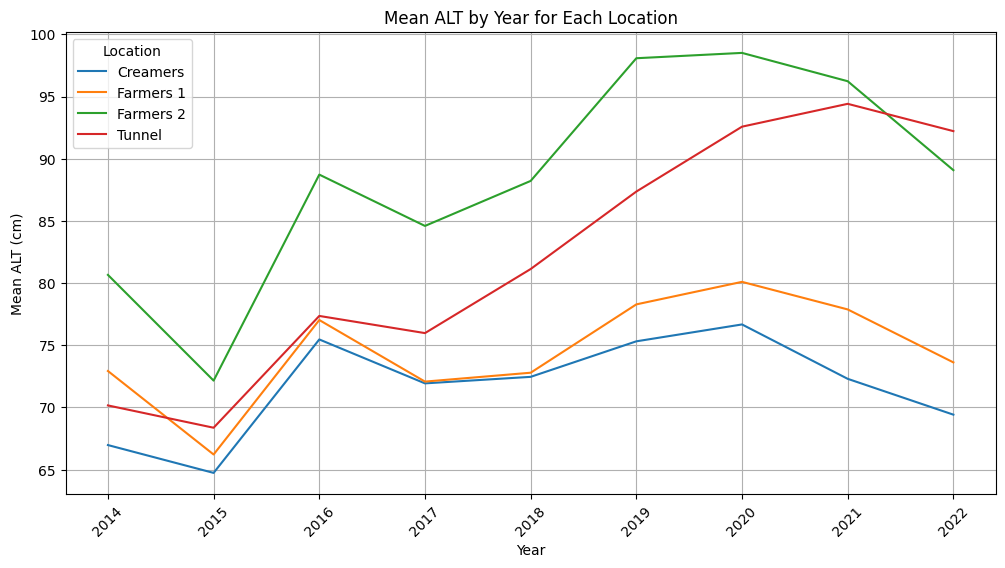

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']

alt_columns_dict = {
    'Creamers': ['CF_10_8_14', 'CF_09_29_15', 'CF_10_10_16', 'CF 10_2017', 'CF 10_5_2018', 'CF 10_15_19', 'CF 10_6_20', 'CF 10_2_21', 'CF_9_28_22'],
    'Farmers 1': ['F1_10_7_14', 'F1_09_29_15', 'F1_10_10_16', 'F1 10_3_2017', 'F1 10_10_18', 'FL1_10_14_19', 'FL1_10_5_20', '9_30_21', 'FL1_9_27_22'],
    'Farmers 2': ['F2_10_7_14', 'F2_09_29_15', 'F2_10_11_16', 'F2_10_17', 'F2_10_10_18', 'F2_10_14_19', 'F2_10_5_2020', '9_30_21', 'F2_9_27_22'],
    'Tunnel': ['PT_10_8_14', 'PT_09_30_15', 'PT_09_29_16', 'PT_10_2_2017', 'PT_10_3_2018', 'PT_10_4_2019', 'PT_10_5_2020', '10_2_21', 'PT_9_26_22']
}

def gather_mean_alt(sheet_name, alt_columns):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    mean_alt_by_year = pd.DataFrame()

    for alt_col in alt_columns:
        year = int(alt_col.split('_')[-1].split()[0][-2:])
        if year < 50:
            year += 2000
        else:
            year += 1900
        
        df['Year'] = year
        df[alt_col] = pd.to_numeric(df[alt_col], errors='coerce')
        year_mean = df.groupby('Year')[alt_col].mean().reset_index()
        year_mean.columns = ['Year', 'Mean_ALT']
        mean_alt_by_year = pd.concat([mean_alt_by_year, year_mean])

    mean_alt_by_year = mean_alt_by_year.groupby('Year')['Mean_ALT'].mean().reset_index()
    mean_alt_by_year['Location'] = sheet_name
    return mean_alt_by_year

all_data = pd.DataFrame()
for sheet in sheets:
    sheet_data = gather_mean_alt(sheet, alt_columns_dict[sheet])
    all_data = pd.concat([all_data, sheet_data])

pivot_data = all_data.pivot(index='Year', columns='Location', values='Mean_ALT')

plt.figure(figsize=(12, 6))
for column in pivot_data:
    plt.plot(pivot_data.index, pivot_data[column], label=column)

plt.title('Mean ALT by Year for Each Location')
plt.xlabel('Year')
plt.ylabel('Mean ALT (cm)')
plt.legend(title='Location')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

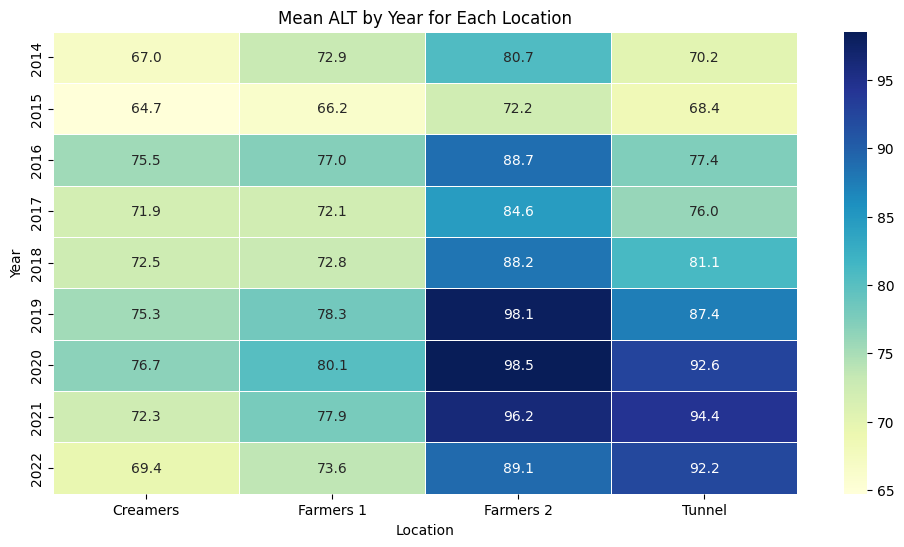

In [89]:
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Mean ALT by Year for Each Location')
plt.xlabel('Location')
plt.ylabel('Year')
plt.show()

In [97]:
ndvitry = '/Users/Azadeh/Downloads/NDVI'
ndvitrylist = glob.glob(os.path.join(ndvitry, '*'))
sortedlist = sorted(ndvitrylist)
for file in ndvitrylist:
    print(file)

print(f"Total number of files: {len(ndvitrylist)}")

/Users/Azadeh/Downloads/NDVI/CF_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif
Total number of files: 16


In [99]:
xds = rio.open_rasterio("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")
xds

<xarray.DataArray (band: 1, y: 195, x: 195)> Size: 152kB
[38025 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 4.644e+05 4.644e+05 ... 4.654e+05 4.654e+05
  * y            (y) float64 2kB 7.195e+06 7.195e+06 ... 7.194e+06 7.194e+06
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  0.004174583158690265
    STATISTICS_MAXIMUM:      0.85118460655212
    STATISTICS_MEAN:         0.71759463681205
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.064611014221186
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0

In [100]:
xds.values

array([[[0.7555074 , 0.75271   , 0.7424651 , ..., 0.72710764,
         0.7388886 , 0.7242467 ],
        [0.7586734 , 0.75271   , 0.75771207, ..., 0.7322539 ,
         0.7210951 , 0.72355574],
        [0.7494297 , 0.7417014 , 0.7528174 , ..., 0.63420534,
         0.7210951 , 0.7210951 ],
        ...,
        [0.5251372 , 0.7748266 , 0.7748266 , ..., 0.8163797 ,
         0.8250431 , 0.81616414],
        [0.5251372 , 0.6926813 , 0.8154578 , ..., 0.8361924 ,
         0.81996906, 0.817226  ],
        [0.6926813 , 0.8016052 , 0.8154578 , ..., 0.8269742 ,
         0.8312072 , 0.817226  ]]], dtype=float32)

In [101]:
xds.rio.crs

CRS.from_epsg(32606)

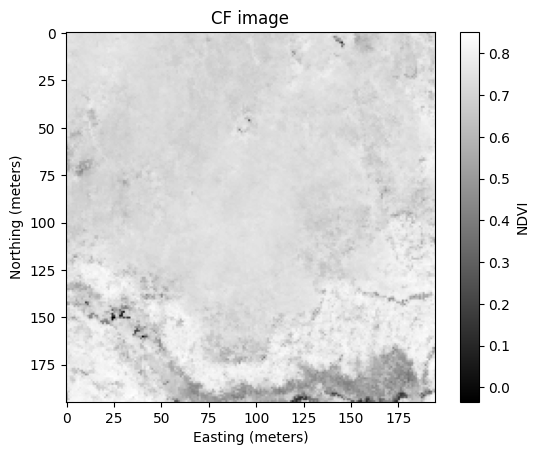

In [175]:
import matplotlib.pyplot as plt
import rasterio as rio
from pyproj import Transformer

plt.imshow(xds[0], cmap='gray')
plt.title('CF image')

plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

plt.colorbar(label='NDVI')

plt.show()


In [103]:
xds.shape[1], xds.shape[2]

(195, 195)

In [105]:
dataset1_utm = rio.open_rasterio("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")

In [106]:
print(dataset1_utm.shape)

(1, 195, 195)


In [152]:
import rasterio
dataset = rasterio.open("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")
print(dataset.crs)
if dataset.crs == 'EPSG:32606':
    print("The dataset is in EPSG:32606 (UTM zone 6N, WGS 84).")
else:
    print("The dataset is in a different CRS.")


EPSG:32606
The dataset is in EPSG:32606 (UTM zone 6N, WGS 84).


In [158]:
from esda.moran import Moran
from libpysal.weights import lat2W

ndvi_values = ndvi_band.flatten()
w = lat2W(ndvi_band.shape[0], ndvi_band.shape[1])

moran = Moran(ndvi_values, w)
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")


Moran's I: 0.816227721109119
P-value: 0.001


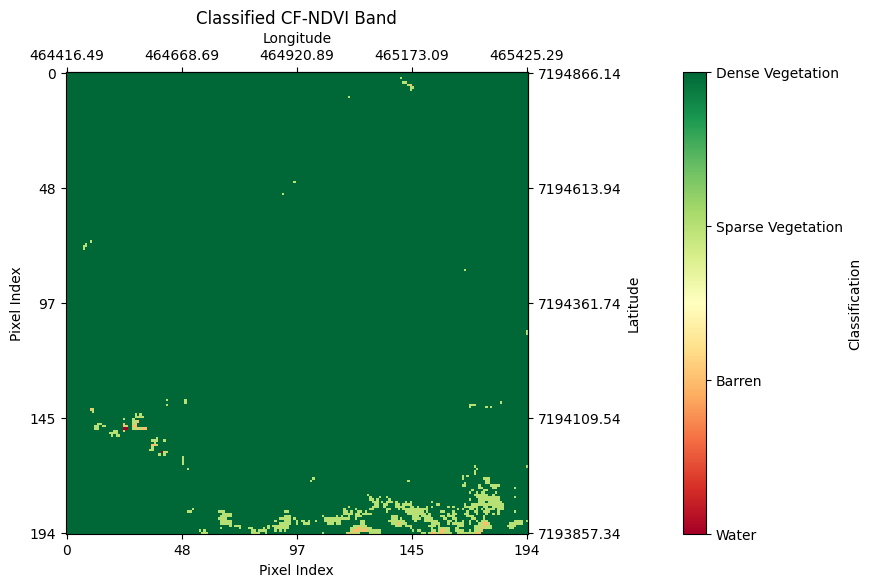

In [84]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(image_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform

def pixel_to_geo(pixel_x, pixel_y, transform):
    geo_x, geo_y = rio.transform.xy(transform, pixel_y, pixel_x)
    return geo_x, geo_y

num_ticks = 5 
x_ticks = np.linspace(0, ndvi_band.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, ndvi_band.shape[0] - 1, num_ticks)
x_labels_geo = [round(pixel_to_geo(x, 0, transform)[0], 2) for x in x_ticks]
y_labels_geo = [round(pixel_to_geo(0, y, transform)[1], 2) for y in y_ticks]

classified_pixels = np.zeros_like(ndvi_band)

classified_pixels[ndvi_band < 0] = 1  # Water
classified_pixels[(ndvi_band >= 0) & (ndvi_band < 0.2)] = 2  # Barren
classified_pixels[(ndvi_band >= 0.2) & (ndvi_band < 0.5)] = 3  # Sparse Vegetation
classified_pixels[ndvi_band >= 0.5] = 4  # Dense Vegetation

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(classified_pixels, cmap='RdYlGn', interpolation='none')  #cmap=viridis
ax.set_title('Classified CF-NDVI Band')

cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4], pad=0.2)
cbar.ax.set_yticklabels(['Water', 'Barren', 'Sparse Vegetation', 'Dense Vegetation'])
cbar.set_label('Classification')

ax.set_xticks(x_ticks)
ax.set_xticklabels([int(x) for x in x_ticks])
ax.set_yticks(y_ticks)
ax.set_yticklabels([int(y) for y in y_ticks])

secax_x = ax.secondary_xaxis('top')
secax_x.set_xticks(x_ticks)
secax_x.set_xticklabels(x_labels_geo)
secax_x.set_xlabel('Longitude')

secax_y = ax.secondary_yaxis('right')
secax_y.set_yticks(y_ticks)
secax_y.set_yticklabels(y_labels_geo)
secax_y.set_ylabel('Latitude')

ax.set_xlabel('Pixel Index')
ax.set_ylabel('Pixel Index')

plt.show()


In [23]:
(classified_pixels == 1).sum()

3

In [24]:
(classified_pixels == 2).sum()

37

In [25]:
(classified_pixels == 3).sum()

652

In [26]:
(classified_pixels == 4).sum()

37333

In [75]:
import rasterio as rio
with rio.open(image_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    pixel_area = abs(transform[0] * transform[4])


In [32]:
import numpy as np
unique_classes, counts = np.unique(classified_pixels, return_counts=True)
areas = counts * pixel_area 

df_classification = pd.DataFrame(list(zip(unique_classes, counts, areas)),
                                 columns=['Class', 'Count', 'Area'])

class_labels = {1: 'Water', 2: 'Barren', 3: 'Sparse Vegetation', 4: 'Dense Vegetation'}
df_classification['Class Label'] = df_classification['Class'].map(class_labels)

total_area = df_classification['Area'].sum()
df_classification['Fraction (%)'] = (df_classification['Area'] / total_area) * 100

print(df_classification[['Class Label', 'Count', 'Area', 'Fraction (%)']])

         Class Label  Count        Area  Fraction (%)
0              Water      3       81.12      0.007890
1             Barren     37     1000.48      0.097304
2  Sparse Vegetation    652    17630.08      1.714661
3   Dense Vegetation  37333  1009484.32     98.180145


In [76]:
import rasterio as rio

# Load the NDVI image
image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(image_file) as src:
    metadata = src.meta
    print("Metadata:", metadata)

    crs = src.crs
    print("Coordinate Reference System (CRS):", crs)

    bounds = src.bounds
    print("Bounds:", bounds)

    transform = src.transform
    print("Transform:", transform)
    
    geo_coords = rio.transform.xy(transform, 0, 0)
    print("Geographical coordinates of pixel (0,0):", geo_coords)

    band_description = src.descriptions[0] if src.descriptions else None
    print("Band Description:", band_description)


Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 195, 'height': 195, 'count': 1, 'crs': CRS.from_epsg(32606), 'transform': Affine(5.2, 0.0, 464413.894,
       0.0, -5.2, 7194868.73508214)}
Coordinate Reference System (CRS): EPSG:32606
Bounds: BoundingBox(left=464413.894, bottom=7193854.73508214, right=465427.894, top=7194868.73508214)
Transform: | 5.20, 0.00, 464413.89|
| 0.00,-5.20, 7194868.74|
| 0.00, 0.00, 1.00|
Geographical coordinates of pixel (0,0): (464416.49399999995, 7194866.135082141)
Band Description: None


GeoDataFrame CRS: epsg:32606


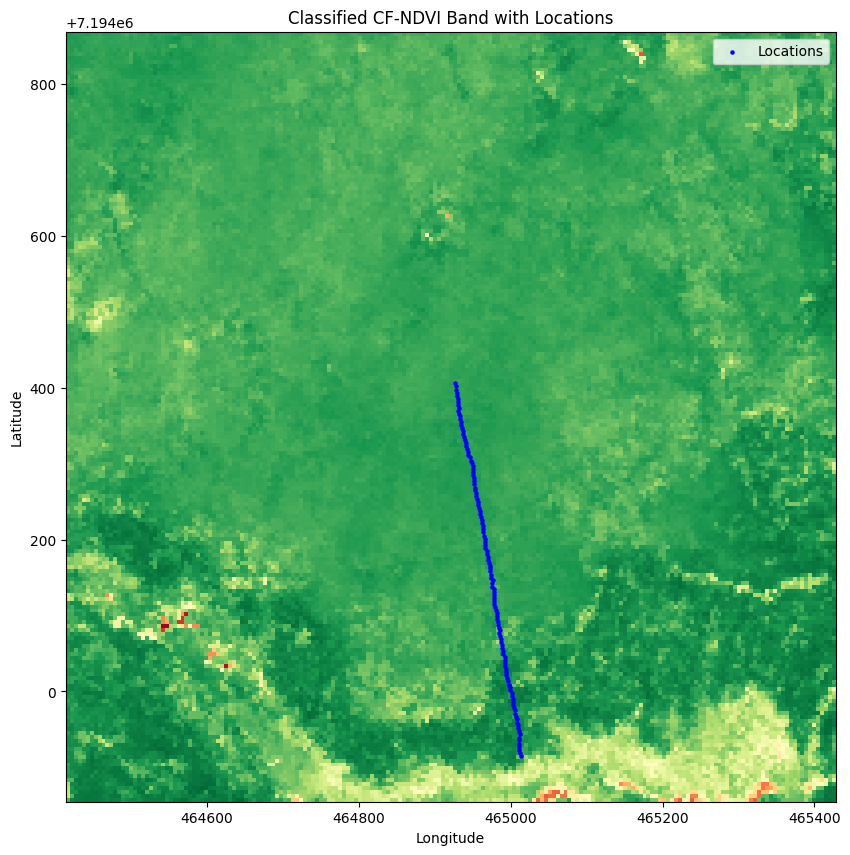

In [86]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

ndvi_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

excel_file = "/Users/Azadeh/CRREL_cleaned.xlsx"
coordinates_df = pd.read_excel(excel_file)

latitudes = coordinates_df['CF_Northing_m'].values
longitudes = coordinates_df['CF_Easting_m'].values

transformer = Transformer.from_crs("epsg:32606", crs.to_string(), always_xy=True)

def reproject_coordinates(x, y):
    return transformer.transform(x, y)

reprojected_coords = [reproject_coordinates(lon, lat) for lon, lat in zip(longitudes, latitudes)]

geometry = [Point(xy) for xy in reprojected_coords]
gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry, crs="epsg:32606")

print("GeoDataFrame CRS:", gdf.crs)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ndvi_band, cmap='RdYlGn', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title('Classified CF-NDVI Band with Locations')

gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Locations')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('/Users/Azadeh/Downloads/NDVI/NDVI_with_Locations.jpg', format='jpeg')
plt.show()


In [174]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

ndvi_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    ndvi_crs = src.crs
    transform = src.transform
    bounds = src.bounds

print("NDVI Image CRS:", ndvi_crs)


NDVI Image CRS: EPSG:32606


In [160]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

reprojected_image_file = "/Users/Azadeh/Downloads/NDVI/reprojected_CFNDVI_image.tif"

with rio.open(image_file) as src:
    dst_crs = 'EPSG:4326'
    
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rio.open(reprojected_image_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [161]:
with rio.open(reprojected_image_file) as src:
    ndvi_band_reprojected = src.read(1)
    transform_reprojected = src.transform

geo_coords_reprojected = rio.transform.xy(transform_reprojected, 0, 0)
print("Geographical coordinates of pixel (0,0) after reprojection:", geo_coords_reprojected)

Geographical coordinates of pixel (0,0) after reprojection: (-147.75113244169546, 64.87626478472961)


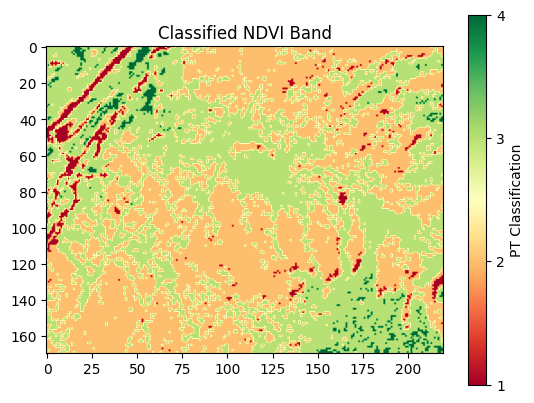

In [89]:
dataset3_utm = rio.open("/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif")
dataset3_utm_np = dataset3_utm.read(1)
classified_pixels = np.zeros_like(dataset3_utm_np)

classified_pixels[dataset3_utm_np < 0] = 1
classified_pixels[(dataset3_utm_np >= 0) & (dataset3_utm_np < 0.2)] = 2
classified_pixels[(dataset3_utm_np >= 0.2) & (dataset3_utm_np < 0.5)] = 3
classified_pixels[dataset3_utm_np >= 0.5] = 4

plt.imshow(classified_pixels, cmap='RdYlGn')
plt.title('Classified NDVI Band')
plt.colorbar(ticks=[0, 1, 2, 3, 4], label='PT Classification')
plt.show()

In [117]:
waterpixels = (classified_pixels == 1).sum()
waterpixels

1096

In [119]:
Barrenpixels = (classified_pixels == 2).sum()
Barrenpixels

18187

In [120]:
Sparsepixels = (classified_pixels == 3).sum()
Sparsepixels

17395

In [121]:
Densepixels = (classified_pixels == 4).sum()
Densepixels

722

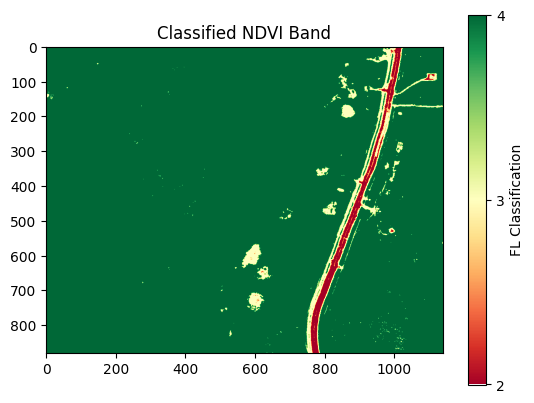

In [90]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

dataset4_utm = rio.open("/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif")

dataset4_utm_np = dataset4_utm.read(1)

classified_pixels = np.zeros_like(dataset4_utm_np)

classified_pixels[dataset4_utm_np < 0] = 1
classified_pixels[(dataset4_utm_np >= 0) & (dataset4_utm_np < 0.2)] = 2
classified_pixels[(dataset4_utm_np >= 0.2) & (dataset4_utm_np < 0.5)] = 3
classified_pixels[dataset4_utm_np >= 0.5] = 4

plt.imshow(classified_pixels, cmap='RdYlGn')
plt.title('Classified NDVI Band')
plt.colorbar(ticks=[1, 2, 3, 4], label='FL Classification')
plt.show()


Mean: 0.7175946235656738, Median: 0.726357102394104, Std Dev: 0.06461016088724136, Min: -0.03446187824010849, Max: 0.851184606552124


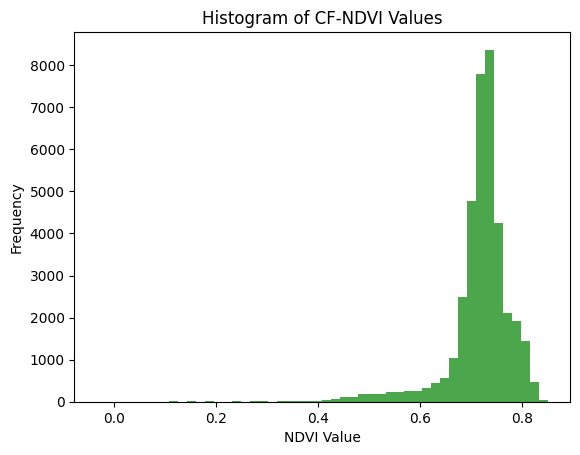

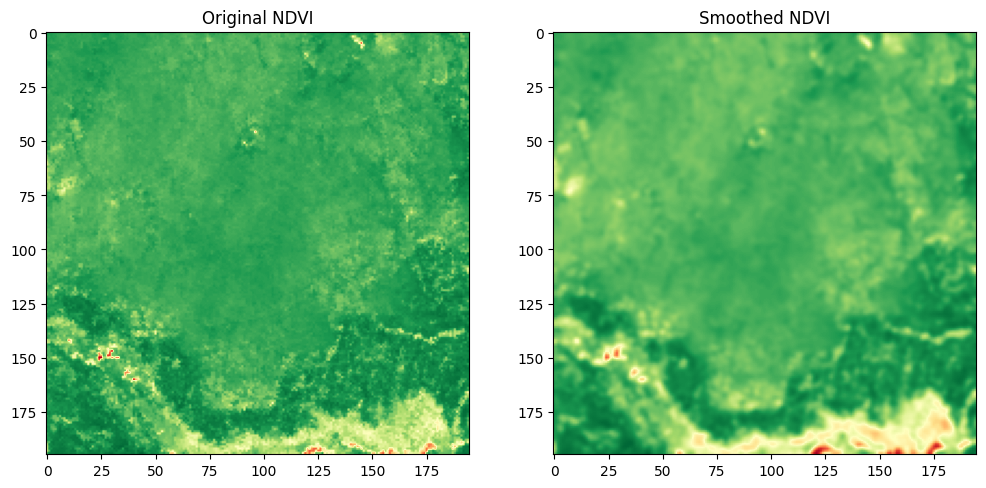

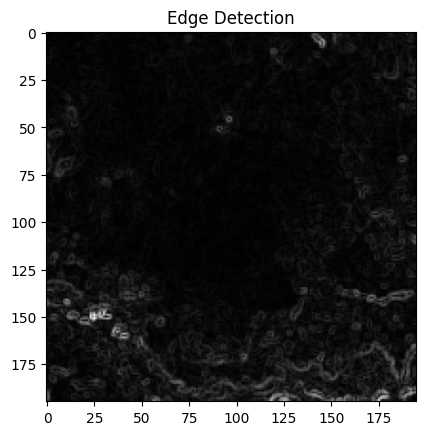

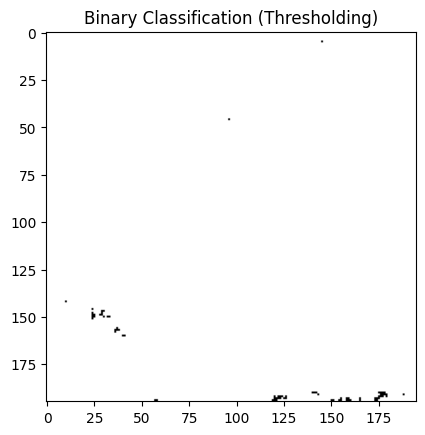

In [134]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import filters

image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"

with rasterio.open(image_file) as src:
    band = src.read(1) 

mean_value = np.mean(band)
median_value = np.median(band)
std_dev = np.std(band)
min_value = np.min(band)
max_value = np.max(band)

print(f"Mean: {mean_value}, Median: {median_value}, Std Dev: {std_dev}, Min: {min_value}, Max: {max_value}")

plt.hist(band.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histogram of CF-NDVI Values')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.show()

smoothed_band = gaussian_filter(band, sigma=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(band, cmap='RdYlGn')
ax[0].set_title('Original NDVI')
ax[1].imshow(smoothed_band, cmap='RdYlGn')
ax[1].set_title('Smoothed NDVI')
plt.show()

edges = filters.sobel(band)

plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.show()

threshold = 0.3
binary_classification = (band > threshold).astype(int)

plt.imshow(binary_classification, cmap='gray')
plt.title('Binary Classification (Thresholding)')
plt.show()


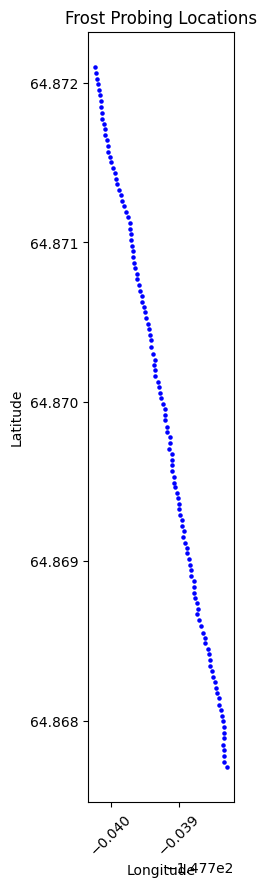

In [182]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

excel_file = '/Users/Azadeh/CRREL_cleaned.xlsx'
df = pd.read_excel(excel_file, sheet_name='Creamers')

if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    geometry = [Point(xy) for xy in zip(df['CF_Easting_m'], df['CF_Northing_m'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    gdf.crs = 'EPSG:32606'
    
    gdf = gdf.to_crs(epsg=4326)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, marker='o', color='blue', markersize=5)
    ax.set_title('Frost Probing Locations')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    plt.xticks(rotation=45)
    
    plt.savefig('frost_probing_locations.jpg', format='jpeg', dpi=300)
    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")


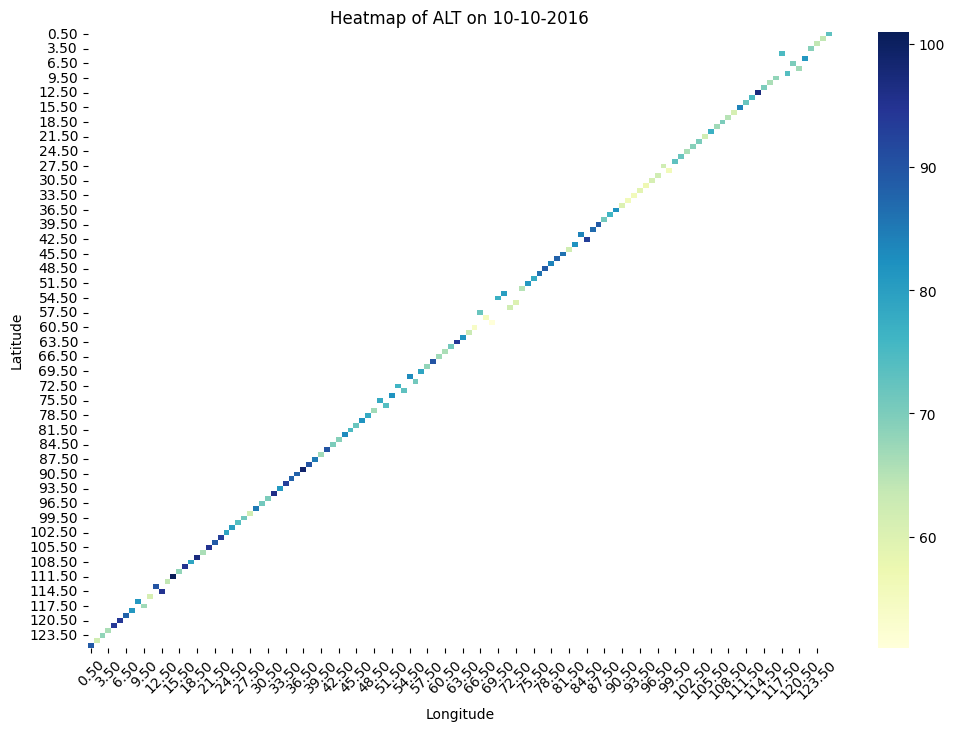

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Transformer

file_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(file_path, sheet_name='Creamers')

if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    transformer = Transformer.from_crs("epsg:32606", "epsg:4326", always_xy=True)

    df[['longitude', 'latitude']] = df.apply(
        lambda row: pd.Series(transformer.transform(row['CF_Easting_m'], row['CF_Northing_m'])), axis=1
    )

    pivot_table = df.pivot_table(values='CF_10_10_16', index='latitude', columns='longitude')

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot_table, cmap="YlGnBu")

    ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], rotation=45)
    ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], rotation=0)

    plt.title('Heatmap of ALT on 10-10-2016')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.savefig('heatmap_ALT_10_10_2016.jpg', format='jpeg', dpi=300)
    
    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")


In [14]:
import pandas as pd

# Path to your Excel file
file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

# Read the Excel file with all sheets
excel_data = pd.read_excel(file_path, sheet_name=None)

# Count the number of rows in each sheet
location_counts = {sheet: len(data) for sheet, data in excel_data.items()}

# Print the results
for sheet, count in location_counts.items():
    print(f"The sheet '{sheet}' has {count} locations.")


The sheet 'Creamers' has 126 locations.
The sheet 'Farmers 1' has 101 locations.
The sheet 'Farmers 2' has 126 locations.
The sheet 'Tunnel' has 92 locations.
The sheet 'NaN_Values' has 46 locations.
